# Fitbit sleep duration analysis
Created by Luke Kippenbrock and last edited on 21 Oct 2019

Look for correlations between Fitbit sleep duration and other Fitbit parameters


## Import modules

In [1]:
from collections import Counter, defaultdict
import csv
import datetime
import json
import math
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import numpy as np
import os
from scipy import stats
import statistics
from typing import Any, Dict, List, NamedTuple 

## Create classes for storing data

In [2]:
#Class for Fitbit sleep event
class SleepEvent(NamedTuple):
    log_id: int
    total_hours: float
    start_time: datetime.datetime
    stop_time: datetime.datetime

#Class for day weather
class DayWeather(NamedTuple):
    date: datetime.date
    temp_max: float
    temp_min: float

#Class for Day
class Day(NamedTuple):
    date: datetime.date
    total_hours: float
    temp_max: float
    temp_min: float

## Create pandas dataframe to store fitibit data

In [3]:
import pandas as pd
dates = pd.date_range(start='1/2/2017', end='8/31/2019')
parameters = ['sleep duration','sleep start time','sleep stop time']
              #'temperature max', 'temperature min']
df_partial = pd.DataFrame(index=dates)#, columns=parameters)
df_partial['weekday'] = df_partial.index.weekday
df_partial['month'] = df_partial.index.month
#print(df_partial)

In [4]:
fitbit_directory_name = "LukeKippenbrock/user-site-export"
fitbit_directory = os.fsencode(fitbit_directory_name)

## Get raw activity data from Fitbit directory
If the data has not preveiously been saved to file (in a dict), then get the data and also save the data to file.  If data has already been saved to file, then load the data from file.
Data is saved in a dictionary, with the key being the date in string format.

In [5]:
def get_fitbit_data(parameter: str, name: str):
    #Check first to see if processed data already exists
    if os.path.exists(f"Processed_Data/{parameter}.csv"):
        df_parameter = pd.read_csv(f"Processed_Data/{parameter}.csv",index_col=0)
        df_parameter.index = pd.to_datetime(df_parameter.index)
    #Otherwise process the data
    else:
        value_dict: Dict[str, float] = defaultdict(float) #Create dict to store date/value pair
        for file in os.listdir(fitbit_directory): #loop through all files in directory
            filename = os.fsdecode(file)
            log_name = parameter
            if "DEFAULT" in parameter:
                log_name = "time_in_heart_rate_zones"
            if log_name in filename: #Only open files for chosen parameter
                filename_with_directory = f"{fitbit_directory_name}/{filename}"
                with open(filename_with_directory,"r") as f:
                    data = f.read()
                    obj = json.loads(data)
                    for value_event in obj:
                        if log_name=="time_in_heart_rate_zones":
                            value = float(value_event["value"]["valuesInZones"][parameter])
                        else:
                            value = float(value_event["value"]) #get value for each value_event
                        string_dt = value_event["dateTime"] #get datetime for each value_event
                        dt = datetime.datetime.strptime(string_dt,'%m/%d/%y %H:%M:%S') #Convert to datetime format
                        #Steps and distance in file are dated according to GMT, which is 7 hours ahead of Seattle, so a shift is necessary
                        if parameter=="steps":
                            dt += datetime.timedelta(hours=-7)
                        if parameter=="distance":
                            dt += datetime.timedelta(hours=-7)
                        string_date = dt.strftime('%m/%d/%Y')
                        value_dict[string_date] += value
        #Save data to file
        df_parameter = pd.DataFrame.from_dict(value_dict, orient='index',columns=[name])
        df_parameter.index = pd.to_datetime(df_parameter.index)
        df_parameter = df_parameter.sort_index()
        df_parameter.to_csv(f"Processed_Data/{parameter}.csv")
    #Add parameter to the pandas dataframe
    df_partial[name] = df_parameter

In [6]:
get_fitbit_data("steps","steps")
get_fitbit_data("distance","distance")
get_fitbit_data("calories","calories")
get_fitbit_data("altitude","altitude")

#Activity data
get_fitbit_data("lightly_active","time lightly active")
get_fitbit_data("moderately_active","time moderately active")
get_fitbit_data("very_active","time very active")
get_fitbit_data("sedentary","time sedentary")

#Heart rate data
get_fitbit_data("BELOW_DEFAULT_ZONE_1","heart rate zone 0")
get_fitbit_data("IN_DEFAULT_ZONE_1","heart rate zone 1")
get_fitbit_data("IN_DEFAULT_ZONE_2","heart rate zone 2")
get_fitbit_data("IN_DEFAULT_ZONE_3","heart rate zone 3")
#print(df)

## Get raw sleep data from Fitbit directory
Sleep data for each sleep event is saved to a dataframe.

In [7]:
def get_sleep_data() -> pd.DataFrame:
    start_time_list = []
    stop_time_list = []
    duration_list = []
    for file in os.listdir(fitbit_directory):
        filename = os.fsdecode(file)
        if "sleep" in filename:
            filename_with_directory = f"{fitbit_directory_name}/{filename}"
            with open(filename_with_directory,"r") as f:
                data = f.read()
                obj = json.loads(data)
                for sleep_event in obj:
                    #if (sleep_event["type"] != "stages"): continue
                    duration_list.append(sleep_event["minutesAsleep"]/60) #Get hours asleep
                    #if 'levels' in sleep_event:
                    #if 'summary' in sleep_event["levels"]:
                    #if 'deep' in sleep_event["levels"]["summary"]:
                    #total_hours = sleep_event["levels"]["summary"]["deep"]["minutes"]/60 #Get hours asleep
                    string_start_time = sleep_event["startTime"] #Get date in string format
                    string_stop_time = sleep_event["endTime"] #Get date in string format
                    start_time = datetime.datetime.strptime(string_start_time,'%Y-%m-%dT%H:%M:%S.000') #Convert to datetime format
                    stop_time = datetime.datetime.strptime(string_stop_time,'%Y-%m-%dT%H:%M:%S.000') #Convert to datetime format
                    start_time_list.append(start_time)
                    stop_time_list.append(stop_time)
    #Save the data in a dataframe
    df_sleep = pd.DataFrame({"stop time":stop_time_list,
                             "duration":duration_list},
                            index=start_time_list)
    df_sleep = df_sleep.sort_index() #Sort by start time
    df_sleep = df_sleep.drop_duplicates() #Remove duplicate sleep events (happens at beginning/end of each file)
    return df_sleep

df_sleep = get_sleep_data()
#print(df_sleep)

## Process sleep data

Several things are done in this code:
- Exclude sleep events that occur when I'm not in Seattle
- Remove any duplicate sleep events (which occur at beginning/end of fitbit files)
- Remove naps (events which start between noon and 8pm and which end before 8pm)
- Combine sleep events that occur during the same night

In [22]:
def process_sleep_data() -> pd.DataFrame:
    date_list = []
    duration_list = []
    sleep_dict = defaultdict(float)
    start_time_list = []
    stop_time_list = []
    sleep_segment_list = []
    previous_date = datetime.date(2000, 8, 30)  #random date in the far past

    #Exclude dates when I was not in Seattle
    #travel_dates is a list of dates in the format
    #travel_dates = [[datetime.date(2016, 12, 20), datetime.date(2017, 1, 4)],...
    from vacation_dates import travel_dates

    #Record all sleep events on the same date (for plotting purposes)
    default_datetime = datetime.datetime(2000, 1, 1, 0, 0, 0);

    for index, row in df_sleep.iterrows():
        start = index
        stop = row['stop time']
        duration = row['duration']
        #Get start hour of sleep event
        start_hour = start.hour
        #Shift date to prior day for start times after midnight til 11am
        if start_hour<11:
            date = start.date() - datetime.timedelta(days=1)
            shift = datetime.timedelta(hours=0)
        #But don't shift date when sleep starts after 11am and before midnight
        else:
            date = start.date()
            shift = datetime.timedelta(hours=-24)
        seattle_date = True
        #Exlude days when not in Seattle
        for date_range in travel_dates:
            travel_start, travel_stop = date_range
            if travel_start <= date <= travel_stop:
                seattle_date = False
                break
        if seattle_date:
            #start = event.start_time
            #stop = event.stop_time
            date_string = date.strftime('%Y-%m-%d')
            #Remove naps
            if 12<=start.hour<20 and stop.hour<20:
                continue
            #Combine sleep records for events with same dates
            elif previous_date==date:
                sleep_segment_list[-1] += 1 
                duration_list[-1] += duration
                stop_timedelta = datetime.timedelta(hours=stop.hour,minutes=stop.minute,seconds=stop.second)
                stop_time_list[-1] = default_datetime + stop_timedelta
                sleep_dict[date_string] += duration
            #Save sleep record
            else:
                sleep_segment_list.append(1)
                date_list.append(date)
                duration_list.append(duration)
                sleep_dict[date_string] = duration
                start_timedelta = datetime.timedelta(hours=start.hour,minutes=start.minute,seconds=start.second)
                start_time_list.append(default_datetime + start_timedelta + shift)
                stop_timedelta = datetime.timedelta(hours=stop.hour,minutes=stop.minute,seconds=stop.second)
                stop_time_list.append(default_datetime + stop_timedelta)
            previous_date = date

    #Convert list of datetime objects to list of "seconds" objects
    start_time_seconds_list = []
    stop_time_seconds_list = []
    for x,y in zip(start_time_list,stop_time_list):
        start_delta = x - default_datetime
        start_time_seconds_list.append(start_delta.total_seconds())
        stop_delta = y - default_datetime
        stop_time_seconds_list.append(stop_delta.total_seconds())
        
    #Save the data in a dataframe
    df_sleep_clean = pd.DataFrame({"start time":start_time_list,
                                   "stop time":stop_time_list,
                                   "start time seconds":start_time_seconds_list,
                                   "stop time seconds":stop_time_seconds_list,
                                   "sleep duration":duration_list,
                                   "sleep segments":sleep_segment_list},
                                index=date_list)
    #df_sleep_clean = df_sleep_clean.sort_index() #Sort by start time
    #print(df_sleep_clean)
    df_sleep_clean.index = pd.to_datetime(df_sleep_clean.index)
    #print(df_sleep_clean)
    return df_sleep_clean

df_sleep_clean = process_sleep_data()
df = df_partial.join(df_sleep_clean)
#print(df)

## Plot sleep duration as a function of time

In [ ]:
#Adjust default figure plotting size
plt.rcParams["figure.figsize"] = (10,7.5)

def plot_time(list_date: List[datetime.datetime], list_other: List[Any], label: str):
    plt.plot(list_date, list_other)
    ax = plt.gcf().axes[0]
    formatter = dates.DateFormatter('%Y-%m')
    #Make the time axis have major ticks for every year and minor ticks for every month
    years = dates.YearLocator()   # every year
    months = dates.MonthLocator()  # every month
    years_fmt = dates.DateFormatter('%Y') #Label only the major ticks
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(years_fmt)
    ax.xaxis.set_minor_locator(months)
    ax.grid(True)
    plt.gcf().autofmt_xdate(rotation=25)
    plt.title(f"{label} vs. Date")
    plt.xlabel("Date")
    plt.ylabel(f"{label}")
    plt.show()
    plt.gca().clear()
    plt.close()

plot_time(date_list, sleep_list, "Hours asleep")
plot_time(date_list, steps_list, "Steps")

In [ ]:
#Functions taken from "Data Science from Scratch", second edition, by Joel Grus
def bucketize(point: float, bucket_size: float) -> float:
    """Floor the point to the next lower multiple of bucket_size"""
    return bucket_size * math.floor(point / bucket_size)

def make_histogram(points: List[float], bucket_size: float) -> Dict[float, int]:
    """Buckets the points and counts how many in each bucket"""
    return Counter(bucketize(point, bucket_size) for point in points)

def plot_histogram(points: List[float], bucket_size: float, title: str = ""):
    histogram = make_histogram(points, bucket_size)
    plt.bar(histogram.keys(), histogram.values(), width=bucket_size)
    plt.title(title)
    plt.show()
    plt.close()
    
plot_histogram(sleep_list,0.2,"Sleep data")

In [ ]:
def plot_variable_histogram(sleep_list: List[float], variable_list: List[float], setting: str):
    mean_list = []
    stdev_list = []
    start = 0
    stop = 7
    if setting=="month":
        start = 1
        stop = 13
    for x in range(start,stop):
        variable_sleep_list = []
        for sleep, variable in zip(sleep_list, variable_list):
            if variable==x:
                variable_sleep_list.append(sleep)
        #print(f"{x} {variable_sleep_list}")
        mean = statistics.mean(variable_sleep_list)
        mean_list.append(mean)
        stdev = statistics.stdev(variable_sleep_list)
        stdev_list.append(stdev)
    #plot_histogram(variable_sleep_list,0.5,f"Day = {x}")
    #Plot sleep duration by weekday (See Ref #2)
    if setting=="weekday":
        N = 7
        ind = np.arange(N)    # the x locations for the groups
        width = 0.50       # the width of the bars: can also be len(x) sequence
        p1 = plt.bar(ind, mean_list, width, yerr=stdev_list)
        plt.ylabel('Sleep duration (hours)')
        plt.title('Sleep duration by day of the week')
        plt.xticks(ind, ('Mon', 'Tues', 'Wed', 'Thurs', 'Fri','Sat','Sun'))
        plt.show()
        plt.close()
    elif setting=="month":
        N = 12
        ind = np.arange(N)    # the x locations for the groups
        width = 0.50       # the width of the bars: can also be len(x) sequence
        p1 = plt.bar(ind, mean_list, width, yerr=stdev_list)
        plt.ylabel('Sleep duration (hours)')
        plt.title('Sleep duration by month')
        plt.xticks(ind, ('Jan', 'Feb', 'Mar', 'Apr', 'May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'))
        plt.show()
        plt.close()

In [ ]:
plot_variable_histogram(sleep_list, weekday_list, "weekday")
plot_variable_histogram(sleep_list, month_list, "month")

## Get Seattle weather data
Record the min and max temperature

In [ ]:
weather_list = []
with open('SeattleWeather.csv') as f:
    comma_reader = csv.reader(f, delimiter=',')
    next(comma_reader) #skip the first row of the file (header row)
    for row in comma_reader:
        string_date = row[2]
        converted_date = datetime.datetime.strptime(string_date, '%Y-%m-%d').date()
        temp_max = float(row[4])
        temp_min = float(row[5])
        day_weather = DayWeather(converted_date, temp_max, temp_min)
        weather_list.append(day_weather)

temp_max_list = []
temp_min_list = []
for date in date_list:
    for day in weather_list:
        if date == day.date:
            temp_max_list.append(day.temp_max)
            temp_min_list.append(day.temp_min)

## Plot sleep duration as a function of other parameters
Look for correlations between sleep duration and the parameters

In [ ]:
def plot_nice(list1: List[Any], list2: List[Any], title: str, label1: str, label2: str):
    plt.plot(list1, list2, 'o', alpha=0.2, label='data')
    # label each point
    '''for x, y, date in zip(list1, list2, date_list):
        plt.annotate(date,
                 xy=(x, y), # Put the label with its point
                 xytext=(5, -5),                  # but slightly offset
                 textcoords='offset points',
                 size=5)'''
    plt.title(title)
    plt.xlabel(label1)
    plt.ylabel(label2)
    
    x = np.asarray(list1)
    y = np.asarray(list2)

    if isinstance(list1[0],datetime.datetime): #For time on x-axis (see Ref #1)
        x = dates.date2num(list1)
        plt.gcf().autofmt_xdate()
        myFmt = dates.DateFormatter('%H:%M')
        plt.gca().xaxis.set_major_formatter(myFmt)
    if isinstance(list2[0],datetime.datetime): #For time on y-axis
        y = dates.date2num(list2)
        myFmt = dates.DateFormatter('%H:%M')
        plt.gca().yaxis.set_major_formatter(myFmt)

    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    #print("slope: %f    intercept: %f" % (slope, intercept))
    print(f"correlation: {r_value} for {title}")
    plt.plot(x, intercept + slope*x, 'r', label='linear fit')
    plt.legend()
    
    ax = plt.gcf().axes[0]
    ax.grid(True)
    #if (r_value**2 >0.05):
    plt.show()
    plt.gca().clear()
    plt.close()

In [ ]:
#plot_nice(heart_below_one_list,sleep_list,"Sleep duration vs. Time below heart zone 1","Time below heart zone 1 (hours)","Sleep duration (hours)")
#plot_nice(heart_zone_one_list,sleep_list,"Sleep duration vs. Time in heart zone 1","Time in heart zone 1 (hours)","Sleep duration (hours)")
#plot_nice(heart_zone_two_list,sleep_list,"Sleep duration vs. Time in heart zone 2","Time in heart zone 2 (minutes)","Sleep duration (hours)")
#plot_nice(heart_zone_three_list,sleep_list,"Sleep duration vs. Time in heart zone 3","Time in heart zone 3 (minutes)","Sleep duration (hours)")

#plot_nice(lightly_active_list,sleep_list,"Sleep duration vs. Lightly active time","Lightly active time (hours)","Sleep duration (hours)")
#plot_nice(moderately_active_list,sleep_list,"Sleep duration vs. Moderately active time","Moderately active time (hours)","Sleep duration (hours)")
#plot_nice(very_active_list,sleep_list,"Sleep duration vs. Very active time","Very active time(hours)","Sleep duration (hours)")
#plot_nice(sedentary_list,sleep_list,"Sleep duration vs. Sedentary time","Sedentary time (hours)","Sleep duration (hours)")

#plot_nice(stairs_list,sleep_list,"Sleep duration vs. Floors","Floors","Sleep duration (hours)")
#plot_nice(distance_list,sleep_list,"Sleep duration vs. Distance","Distance (miles)","Sleep duration (hours)")
#plot_nice(calories_list,sleep_list,"Sleep duration vs. Calories","Calories","Sleep duration (hours)")
#plot_nice(steps_list,sleep_list,"Sleep duration vs. Steps","Steps","Sleep duration (hours)")

#plot_nice(temp_max_list,sleep_list,"Sleep duration vs. Max temperature","Max temperature ($^\circ$F)","Sleep duration (hours)")
#plot_nice(temp_min_list,sleep_list,"Sleep duration vs. Min temperature","Min temperature ($^\circ$F)","Sleep duration (hours)")

#plot_nice(previous_day_sleep_list,current_day_sleep_list,"Sleep duration vs. Previous day's sleep","Previous day's sleep (hours)","Sleep duration (hours)")

plot_nice(start_time_list,sleep_list,"Sleep duration vs. Start time","Sleep start time","Sleep duration (hours)")
plot_nice(stop_time_list,sleep_list,"Sleep duration vs. Stop time","Sleep stop time","Sleep duration (hours)")

## Correlation matrix

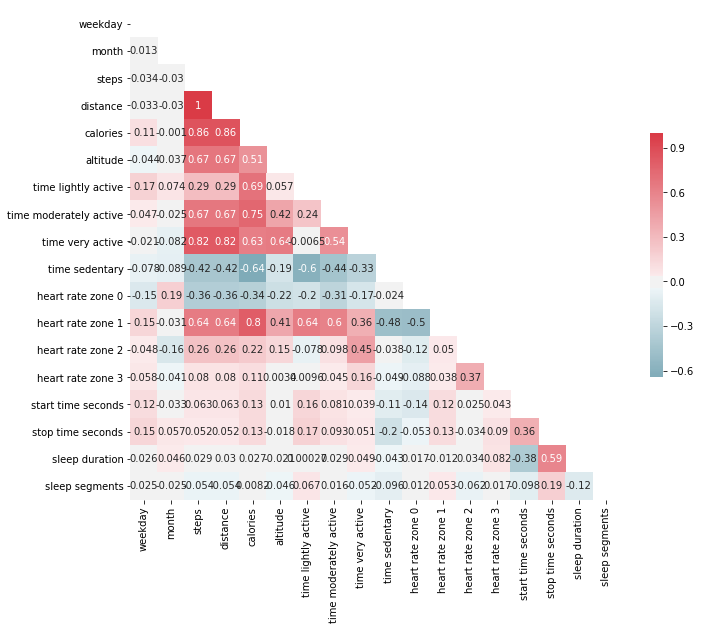

In [10]:
import seaborn as sns

# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, center=0,
            square=True, cbar_kws={"shrink": .5})

plt.show()

#plot_time(date_list, d['sleep duration'], "Sleep")
#df.head()

## Linear regression
Code based on example given in [Ref #3](#References)

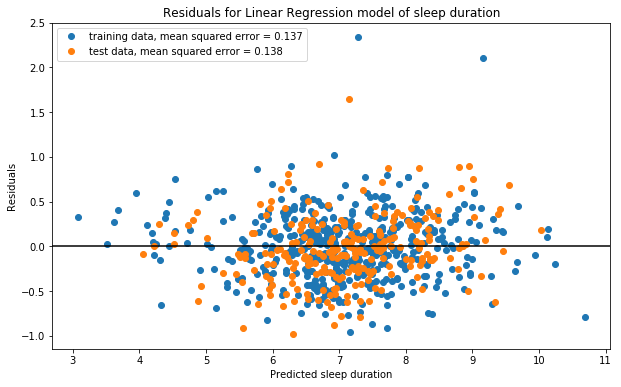

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression

df_lr = df
#X = df[['sleep start time', 'sleep stop time']]
df_lr = df_lr.drop('start time',axis='columns')
df_lr = df_lr.drop('stop time',axis='columns')
df_lr = df_lr.reset_index()
df_lr = df_lr.drop('index',axis='columns')
df_lr = df_lr.dropna(how='any')
#print(df_lr)
y = df_lr['sleep duration']
df_lr = df_lr.drop('sleep duration',axis='columns')
X = df_lr

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=5)
#print(X_train.shape)
#print(X_test.shape)

lm = LinearRegression()
lm.fit(X_train, y_train)
pred_train = lm.predict(X_train)
pred_test = lm.predict(X_test)

MSE_train = np.mean((y_train - pred_train)**2)
MSE_test = np.mean((y_test - pred_test)**2)

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(10, 6))
plt.plot(pred_train, pred_train - y_train, 'o', label='training data, mean squared error = {0:.3f}'.format(MSE_train))
plt.plot(pred_test, pred_test - y_test, 'o', label='test data, mean squared error = {0:.3f}'.format(MSE_test))
ax.axhline(y=0, color='k')
plt.legend()
plt.title('Residuals for Linear Regression model of sleep duration')
plt.xlabel('Predicted sleep duration')
plt.ylabel('Residuals')
plt.show()

f_values, p_values = f_regression(X, y)

## Feature Importance

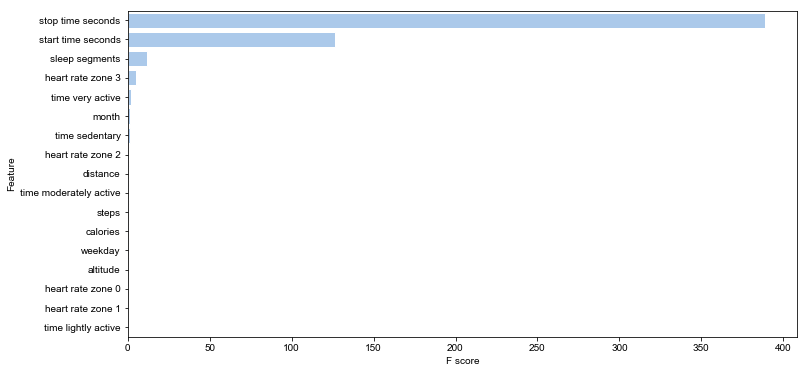

In [15]:
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(12, 6))

#Features sorted by F scores
ff = pd.DataFrame({'Feature':X.columns,
                    'F score':f_values})
ff = ff.sort_values(by='F score', ascending=False)

#Plot the features and F scores
sns.set_color_codes("pastel")
sns.set_style("whitegrid")
sns.barplot(x="F score", y="Feature", data=ff, color="b")

## Feature importance from Gradient Boosting
This code is taken from [Ref #4](#References) with small modifications.

MSE: 0.2038


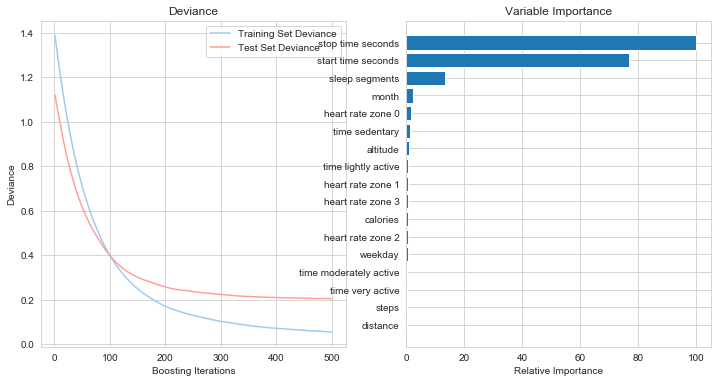

In [19]:
from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

# #############################################################################
# Fit regression model
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)

clf.fit(X_train, y_train)
mse = mean_squared_error(y_test, clf.predict(X_test))
print("MSE: %.4f" % mse)

# #############################################################################
# Plot training deviance

# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_test)):
    test_score[i] = clf.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

# #############################################################################
# Plot feature importance
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

## References 
Ref #1 = https://stackoverflow.com/questions/1574088/plotting-time-in-python-with-matplotlib/16428019#16428019

Ref #2 = https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/bar_stacked.html#sphx-glr-gallery-lines-bars-and-markers-bar-stacked-py

Ref #3 = https://bigdata-madesimple.com/how-to-run-linear-regression-in-python-scikit-learn/

Ref #4 = https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html
